# Video Games Review: Analysis

In this project, I explore [Metacritic's video games reviews](https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0).


## Setup

In this section, I import all necessary libraries, setup the SQLite database, and then import the input `.csv` files in a format that allows manipulation by both `sqlite` and `pandas`:


In [2]:
import pandas as pd
from sqlalchemy import create_engine

# creating SQLite database
engine = create_engine("sqlite://", echo=False)


In [6]:
df = pd.read_csv("./input/input.csv")
df.groupby("platform").name.count().reset_index()

,platform,name
0,3DS,13
1,DS,24
2,Dreamcast,2
3,Game Boy Advance,8
4,GameCube,6
5,Nintendo 64,1
6,PC,809
7,PSP,11
8,PlayStation,3
9,PlayStation 2,19


## Cleaning

### Removing string prefix in `platform` column

As all values in the `platform` column has a `"Platform: "` prefix, I use SQL's `SUBSTR()` to begin the string at a later index.

If the the unwanted substring is not consistently a prefix, I would use `REPLACE()` instead.


In [ ]:
# displaying distinct values of `platform` column to confirm all values start with prefix
merged_df.to_sql("games", engine, if_exists="replace", index=False)
pd.read_sql_query("SELECT DISTINCT platform FROM games", engine)


In [ ]:
merged_df = pd.read_sql_query(
    """
    SELECT name,
        SUBSTR(platform, 11) platform,
        release_date,
        summary,
        meta_score,
        user_score
    FROM 
        games
        """,
    engine,
)
merged_df.head()


### Missing Values

Though there are missing values in the dataset, there is NFA to impute as:

1. The `meta_score` and `user_score` columns are missing if there are <4 and <7 reviews for that game respectively, and is not possible to impute.
2. The `summary` of the game is authored by Metacritic, which is also difficult to impute.


In [ ]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN meta_score IS NULL THEN 1 ELSE 0 END) meta_score_miss,
        SUM(CASE WHEN user_score IS NULL THEN 1 ELSE 0 END) user_score_miss,
        SUM(CASE WHEN name IS NULL THEN 1 ELSE 0 END) name_miss,
        SUM(CASE WHEN platform IS NULL THEN 1 ELSE 0 END) platform_miss,
        SUM(CASE WHEN release_date IS NULL THEN 1 ELSE 0 END) release_date_miss,
        SUM(CASE WHEN summary IS NULL THEN 1 ELSE 0 END) summary_miss
    FROM games
    """,
    engine,
)


### Duplicates


In [ ]:
# deduplicate first as no entries should be identical for all columns
merged_df = merged_df.drop_duplicates()
merged_df.to_sql("games", engine, if_exists="replace", index=False)

# check duplicates for "name", "summary" columns, as the other attributes can be expected to have duplicates
# exclude null values using `WHERE` statement as these will duplicate
for col in ["name", "summary"]:
    dup_df = pd.read_sql_query(
        f"""
        SELECT {col}, COUNT(*) counts
        FROM games
        WHERE {col} NOT NULL
        GROUP BY 1
        HAVING counts > 1
        ORDER BY 2 DESC
        """,
        engine,
    )
    if not dup_df.empty:
        display(col, dup_df)


The `name` column has duplicates largely due to each row representing a game for a particular _platform_. Eg: if a game was released on PC, PS4 and PS5 -- each of these will have its own entry.

However, if there are games that also duplicate when the `name` and `platform` columns are grouped, the entry that has incorrect attributes should be removed.

In [ ]:
pd.read_sql_query(
    """
    SELECT name,
        platform,
        COUNT(*) counts
    FROM games
    GROUP BY 1, 2
    HAVING counts > 1
    ORDER BY 3 DESC
    """,
    engine,
)


In [ ]:
# find entries for above games (and their platform) which duplicates
# create "name_platform" helper column to identify unique name+platform pairs
dups_df = pd.read_sql_query(
    """
    WITH dups_name_platform AS (
        SELECT name, 
            platform,
            COUNT(*) counts
        FROM games
        GROUP BY 1, 2
        HAVING counts > 1
    )
    
    SELECT g.*,
        REPLACE(LOWER(name), ' ', '-') || '//' || REPLACE(LOWER(platform), ' ', '-') name_platform
    FROM games g
    JOIN dups_name_platform
    USING (name, platform)
    """,
    engine,
)

dups_df


In [ ]:
# confirm on site the actual score of the duplicated entry
from scraper import setup_chrome_driver
from selenium.webdriver.common.by import By

if not dups_df.empty:
    DRIVER = setup_chrome_driver()
    for n in set(dups_df.name_platform):
        name_platform_split = n.split("//")
        game_name_cleaned = name_platform_split[0]
        platform_name_cleaned = name_platform_split[1]

        game_url = f"https://www.metacritic.com/game/{platform_name_cleaned}/{game_name_cleaned}"

        DRIVER.get(game_url)
        metascore_indiv = float(
            DRIVER.find_element(
                By.XPATH,
                '//*[@id="main"]/div/div[1]/div[1]/div[3]/div/div[2]/div[1]/div[1]/div/div/a/div',
            ).text
        )
        userscore_indiv = float(
            DRIVER.find_element(
                By.XPATH,
                '//*[@id="main"]/div/div[1]/div[1]/div[3]/div/div[2]/div[1]/div[2]/div[1]/div/a/div',
            ).text
        )

        # check that a row with those values exist
        check_entry_df = dups_df[
            (dups_df.name_platform == n)
            & (dups_df.meta_score == float(metascore_indiv))
            & (dups_df.user_score == float(userscore_indiv))
        ]
        if check_entry_df.empty:
            raise Exception(
                f"""The game "{check_entry_df.name.values[0]}" on "{check_entry_df.platform.values[0]}" has incorrect Metascore and/or User Score. Please re-run scraper.py or manually update the CSV(s)."""
            )

        # replace scores with correct ones and dedup
        game_name = check_entry_df.name.values[0]
        platform_name = check_entry_df.platform.values[0]

        merged_df.loc[
            (merged_df.name == game_name) & (merged_df.platform == platform_name),
            ["meta_score"],
        ] = metascore_indiv
        merged_df.loc[
            (merged_df.name == game_name) & (merged_df.platform == platform_name),
            ["user_score"],
        ] = userscore_indiv

        merged_df.drop_duplicates(inplace=True)

        display(merged_df[merged_df.name == check_entry_df.name.values[0]])
    DRIVER.close()


Similarly, `summary` column duplicates due to each row referring to a game that, despite being released on different platforms, have the same game summary.

In [ ]:
merged_df.to_sql("games", engine, if_exists="replace", index=False)

pd.read_sql_query(
    """
    SELECT name,
        platform,
        summary,
        COUNT(*) counts
    FROM games
    WHERE summary NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    """,
    engine,
)


## Analysis

### Metascore vs User Scores
There are up to two scores (assuming sufficient rating volumes) for each game: 
* A game's **Metascore** is the [weighted average of critics' and publications' reviews](https://www.metacritic.com/about-metascores).
* A game's **user score** is the mean of users' scores.

#### Metascores and user scores have a ***low***, ***positive*** correlation
The Pearson Correlation Coefficient is approx `+0.270`.

Unlike other SQL implementations (like PostgreSQL's `CORR()`), SQLite lacks built-in function to calculate the correlation coefficient. Thus, I implement the calculation manually using the formula:

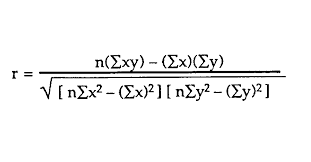

In [ ]:
pd.read_sql_query(
    """
    SELECT AVG( (user_score - avg_userscore) * (meta_score - avg_metascore) ) * AVG( (user_score - avg_userscore) * (meta_score - avg_metascore) ) / (var_userscore * var_metascore) AS pearson_corr_coeff 
    FROM games,
        (
            SELECT avg_userscore,
                avg_metascore,
                AVG((user_score - avg_userscore)*(user_score - avg_userscore)) as var_userscore,
                AVG((meta_score - avg_metascore)*(meta_score - avg_metascore)) as var_metascore
            FROM games,
                (
                    SELECT AVG(user_score) AS avg_userscore,
                        AVG(meta_score) AS avg_metascore
                    FROM games
                )
        )
    """,
    engine,
)


Visually, a scatterplot of all games' user score (x-axis) against Metascore (y-axis) validates this positive correlation.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.lmplot(
    data=merged_df,
    x="user_score",
    y="meta_score",
    scatter_kws={"color": "brown", "alpha": 0.08, "s": 20},
    line_kws={"color": "#595959"},
)
plt.show()


### Platforms

#### **Nintendo 64** and **PlayStation** have the highest rated games

In [ ]:
# transforming table to allow split boxplots
# normalise meta_score by having it out of 10 instead of 100

scores_stacked_df = pd.read_sql_query(
    """
    SELECT name,
        platform,
        meta_score / 10 score, 
        'meta' score_type,
        release_date
    FROM games
    WHERE score NOT NULL
    UNION ALL
    SELECT name,
        platform,
        user_score score,
        'user' score_type,
        release_date
    FROM games
    WHERE score NOT NULL
    ORDER BY platform
""",
    engine,
)
scores_stacked_df.head(3)


As SQLite does not have a built-in function nor efficient alternative to query the median values of each platform, we use `pandas`' `.median()` method:

In [ ]:
median_scores_df = (
    scores_stacked_df.groupby(["platform", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
median_scores_df


With the exception of Nintendo DS and Nintendo Wii, Metascores' distribution for each platform is similar to one another.

**Nintendo DS** and **Nintendo Wii** have lower, median and interquartile ranges of _Metascores_, though _users_ have reviewed games of other platforms lower.

Overall, the higher number of outliers for _user_ scores (as compared to Metascores) imply users tend to disagree with one another more than critics, which is expected. In particular, **PC** games have noticeably more low-end outliers, especially for user scores <4.


In [ ]:
plt.figure(figsize=(8, 10))
bp = sns.boxplot(
    data=scores_stacked_df,
    x="score",
    y="platform",
    hue="score_type",
    orient="h",
    palette=["orange", "#2998cd"],
)
plt.show()


#### Overall, users agree that **_handheld_** games are better

- Across all platform types, Metascores vary far more between games than user scores.
- Overall, users tend to rate **_handheld_** games the highest, followed by "hybrid" games (which refers to the Nintendo Switch, which can be played both as a _handheld_ platform and a home console).
- _PC_ games have the lowest median user scores, albeit only slightly compared to the other categories


In [ ]:
platform_type_df = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM games
    """,
    engine,
)
platform_type_df.head(3)


In [ ]:
# transforming table in preparation for split boxplot
scores_stacked_df.to_sql("scores_unpivoted", engine, if_exists="replace", index=False)
scores_unpivoted_platform_cats = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM scores_unpivoted
    """,
    engine,
)

plt.figure(figsize=(10, 8))
sns.violinplot(
    data=scores_unpivoted_platform_cats,
    x="platform_type",
    y="score",
    hue="score_type",
    palette=["orange", "#2998cd"],
    split=True,
)
plt.show()


### Older Games Tend to Be More Popular

As SQLite does not support month names ([StackOverflow](https://stackoverflow.com/questions/1181123/date-formatting-from-sqlite-query)) as is found in the `release_date` column, we use [`pandas.to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) method instead:


In [ ]:
merged_df["release_date"] = pd.to_datetime(merged_df.release_date, format="%B %d, %Y")
merged_df.head(2)


#### Games released in ***1995-1999*** inclusive tend to have higher user scores and Metascores...
Which aligns with our findings above that N64 (released 1996) and PS1 (released 1994) had the highest rated games
- As time goes by, newer-released games tend to attract _lower_ user scores (although there are exceptions, in the form of outliers)
- Games released in 2006-2008 inclusive attracted poorer Metascores  

In [ ]:
sns.scatterplot(
    data=merged_df, x="release_date", y="meta_score", alpha=0.05, color="orange"
)
plt.show()


In [ ]:
sns.scatterplot(
    data=merged_df, x="release_date", y="user_score", alpha=0.05, color="#2998cd"
)
plt.show()


In [ ]:
scores_stacked_df["release_date"] = pd.to_datetime(
    scores_stacked_df.release_date, format="%B %d, %Y"
)

plt.figure(figsize=(10, 8))
sns.boxplot(
    data=scores_stacked_df,
    x=scores_stacked_df.release_date.dt.year,
    y="score",
    hue="score_type",
    palette=["orange", "#2998cd"],
)
plt.xticks(rotation=90)
plt.show()


Median scores (which are less sensitive to outliers compared to mean) confirm these findings:
1. Median user scores decline as the game is released more recently, reaching a historical low for games released in 2023
2. Median Metascores have stayed around `7.0` following a dip for games released 2006-2008 inclusive.

In [ ]:
scores_stacked_by_year = scores_stacked_df.copy().drop("platform", axis=1)
scores_stacked_by_year["release_year"] = scores_stacked_by_year.release_date.dt.year
median_scores_by_year = (
    scores_stacked_by_year.groupby(["release_year", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
# median_scores_by_year.head(5)

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=median_scores_by_year,
    x="release_year",
    y="median_score",
    hue="score_type",
    palette=["orange", "#2998cd"], linewidth=3
)
plt.show()
